In [19]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import skimage
import random
from skimage.transform import resize
import matplotlib.pyplot as plt

In [5]:
# device = 'mps' 
device = 'mps'

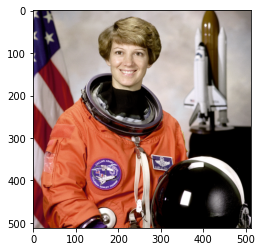

In [6]:
#Get colour image from skimage
img = skimage.data.astronaut()
smaller_img = resize(img, (64, 64)) # Resize it just to make things quicker
plt.imshow(img)

In [48]:
#Our function that gets a grid of coordinates
def get_mgrid(sidelen):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    width = np.linspace(-1, 1, sidelen)
    height = np.linspace(-1, 1, sidelen)
    mgrid = np.stack(np.meshgrid(width, height), axis=-1)
    mgrid = np.reshape(mgrid, [-1, 2])
    return mgrid

Getting the input coords.


In [49]:
image_side_length = smaller_img.shape[0]
X = get_mgrid(image_side_length)      # Inputs
X = np.float32(X)

print(X.shape)

(4096, 2)


In [9]:
import torchvision.transforms as transforms

In [10]:
#Convert input array to torch tensor
X_torch_tensor = torch.tensor(X, device=device)

y = np.reshape(smaller_img, [-1, 1])# Outputs
y = np.float32(y)

#convert output array to torch tensor
y_torch_tensor = torch.tensor(y, device=device)

#Get the total number of coordinates 
num_coords = X_torch_tensor.shape[0]

In [11]:
num_input_features = original_tensor.shape[1]
print(f"The number of input features in the tensor is: {num_input_features}")

mps:0


In [15]:
# Define the model architecture
class CPPN(nn.Module):
    def __init__(self):
        super(CPPN, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [16]:
# Set the hyperparameters
num_coords = 1000
num_epochs = 10
batch_size = 32
learning_rate = 0.001

Epoch [1/10], Step [0/312], Loss: 0.09687718749046326
Epoch [2/10], Step [0/312], Loss: 0.08410373330116272
Epoch [3/10], Step [0/312], Loss: 0.0847870409488678
Epoch [4/10], Step [0/312], Loss: 0.08202715963125229
Epoch [5/10], Step [0/312], Loss: 0.0767669826745987
Epoch [6/10], Step [0/312], Loss: 0.08131098002195358
Epoch [7/10], Step [0/312], Loss: 0.09314551204442978
Epoch [8/10], Step [0/312], Loss: 0.08713070303201675
Epoch [9/10], Step [0/312], Loss: 0.08338794857263565
Epoch [10/10], Step [0/312], Loss: 0.0815035030245781


(-0.5, 99.5, 99.5, -0.5)

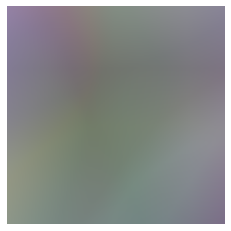

In [20]:
# Create the model and optimizer
cppn = CPPN()
optimizer = optim.Adam(cppn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i in range(int((num_coords * num_epochs) / batch_size)):
        optimizer.zero_grad()

        # Select a batch of data
        batch_indexes = np.random.choice(num_coords, batch_size, replace=False)
        input_batch = X_torch_tensor[batch_indexes]
        target_batch = y_torch_tensor[batch_indexes]

        # Forward pass
        output_batch = cppn(input_batch)

        # Calculate the loss
        loss = nn.MSELoss()(output_batch, target_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the loss every 1000 steps
        if i % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{int((num_coords * num_epochs) / batch_size)}], Loss: {loss.item()}")

# Generate RGB colors for a grid of coordinates
grid_size = 100
grid = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
grid_flat = np.vstack((grid[0].flatten(), grid[1].flatten())).T
grid_torch_tensor = torch.from_numpy(grid_flat).float()
output_grid = cppn(grid_torch_tensor).detach().numpy()

# Plot the generated RGB colors
plt.imshow(output_grid.reshape(grid_size, grid_size, 3))
plt.axis('off')

In [21]:
with torch.no_grad():
    prediction = cppn(X_torch_tensor)

In [25]:
prediction.shape

torch.Size([1000, 3])

In [50]:
# Look at the first 10 values of the output.
print(prediction[:10])


tensor([[0.4729, 0.4065, 0.4329],
        [0.5274, 0.4533, 0.5976],
        [0.4645, 0.5141, 0.4751],
        [0.4437, 0.4518, 0.5342],
        [0.5088, 0.4912, 0.4821],
        [0.5073, 0.5468, 0.5099],
        [0.4283, 0.4674, 0.4330],
        [0.4938, 0.5333, 0.4976],
        [0.4911, 0.4723, 0.4736],
        [0.4688, 0.4999, 0.5081]])


In [51]:
min_val = prediction.min()
max_val = prediction.max()

print(min_val, max_val)

tensor(0.3958) tensor(0.6135)


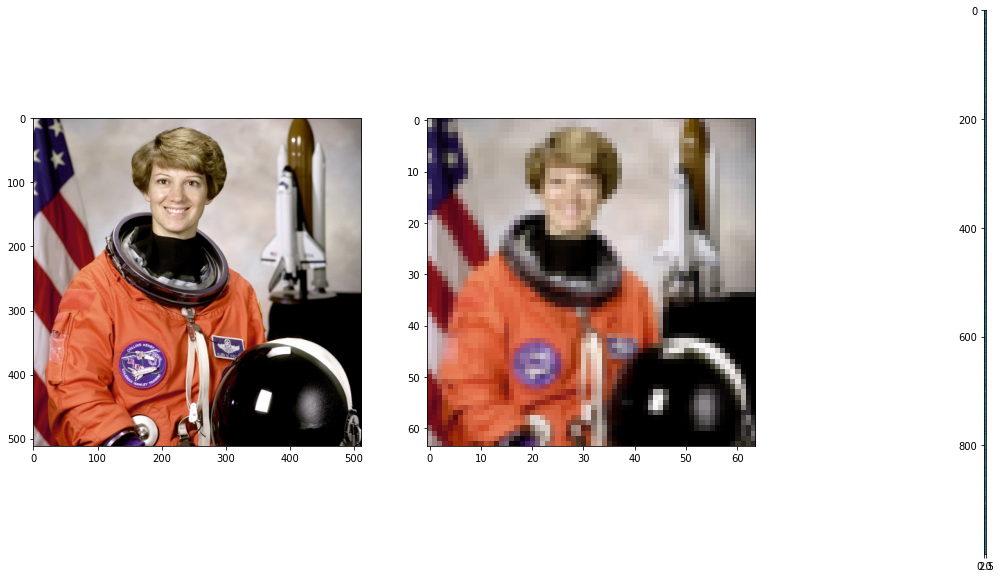

In [26]:
# Scale the values from [0,1] to [0, 255]
reconstructed_img = prediction.cpu() * 255

# Convert the tensor into a numpy array, and cast the type into uint8.
reconstructed_img = reconstructed_img.numpy().astype(np.uint8)

# Look at our creation next to the original!
fig, axes_array = plt.subplots(1, 3, figsize=(20, 10))
axes_array[0].imshow(img)
axes_array[1].imshow(smaller_img)
axes_array[2].imshow(reconstructed_img)
plt.show()

In [33]:
# Set the hyperparameters
num_coords = 1000
learning_rate = 0.001
batch_size = 32
num_epochs = 10

Epoch [1/10], Step [0/312], Loss: 0.3596142530441284
Epoch [2/10], Step [0/312], Loss: 0.07447633892297745
Epoch [3/10], Step [0/312], Loss: 0.07730744034051895
Epoch [4/10], Step [0/312], Loss: 0.08605065941810608
Epoch [5/10], Step [0/312], Loss: 0.07768429815769196
Epoch [6/10], Step [0/312], Loss: 0.09929292649030685
Epoch [7/10], Step [0/312], Loss: 0.07636018842458725
Epoch [8/10], Step [0/312], Loss: 0.07815497368574142
Epoch [9/10], Step [0/312], Loss: 0.0800330713391304
Epoch [10/10], Step [0/312], Loss: 0.07852810621261597


(-0.5, 99.5, 99.5, -0.5)

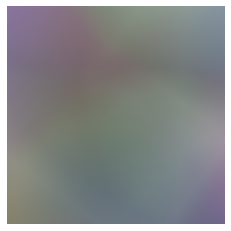

In [34]:
# Create the model and optimizer
cppn = CPPN()
optimizer = optim.Adam(cppn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i in range(int((num_coords * num_epochs) / batch_size)):
        optimizer.zero_grad()

        # Select a batch of data
        batch_indexes = np.random.choice(num_coords, batch_size, replace=False)
        input_batch = X_torch_tensor[batch_indexes]
        target_batch = y_torch_tensor[batch_indexes]

        # Forward pass
        output_batch = cppn(input_batch)

        # Calculate the loss
        loss = nn.MSELoss()(output_batch, target_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the loss every 1000 steps
        if i % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{int((num_coords * num_epochs) / batch_size)}], Loss: {loss.item()}")

# Generate RGB colors for a grid of coordinates
grid_size = 100
grid = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
grid_flat = np.vstack((grid[0].flatten(), grid[1].flatten())).T
grid_torch_tensor = torch.from_numpy(grid_flat).float()
output_grid = cppn(grid_torch_tensor).detach().numpy()

# Plot the generated RGB colors
plt.imshow(output_grid.reshape(grid_size, grid_size, 3))
plt.axis('off')

In [35]:
with torch.no_grad():
    prediction = cppn(X_torch_tensor)

In [67]:
class CPPN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CPPN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [71]:
# Define the input, hidden, and output dimensions
input_dim = 2  # Modify this value based on your input data
hidden_dim = 64  # Modify this value based on your desired hidden dimension
output_dim = 3  # Modify this value based on your desired output dimension

# Create the model and optimizer
cppn = CPPN(input_dim, hidden_dim, output_dim)
optimizer = optim.SGD(cppn.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
for epoch in range(num_epochs):
    for i in range(int((num_coords * num_epochs) / batch_size)):
        optimizer.zero_grad()

        # Select a batch of data
        batch_indexes = np.random.choice(num_coords, batch_size, replace=False)
        input_batch = X_torch_tensor[batch_indexes]
        target_batch = y_torch_tensor[batch_indexes]

        # Forward pass
        output_batch = cppn(input_batch)

        # Calculate the loss
        loss = nn.MSELoss()(output_batch, target_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the loss every 1000 steps
        if i % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{int((num_coords * num_epochs) / batch_size)}], Loss: {loss.item()}")

Epoch [1/10], Step [0/312], Loss: 0.08804518729448318
Epoch [2/10], Step [0/312], Loss: 0.0850851833820343
Epoch [3/10], Step [0/312], Loss: 0.08314818143844604
Epoch [4/10], Step [0/312], Loss: 0.08940436691045761
Epoch [5/10], Step [0/312], Loss: 0.08672311156988144
Epoch [6/10], Step [0/312], Loss: 0.0637693777680397
Epoch [7/10], Step [0/312], Loss: 0.07818014174699783
Epoch [8/10], Step [0/312], Loss: 0.07830170542001724
Epoch [9/10], Step [0/312], Loss: 0.0745638906955719
Epoch [10/10], Step [0/312], Loss: 0.0820365697145462


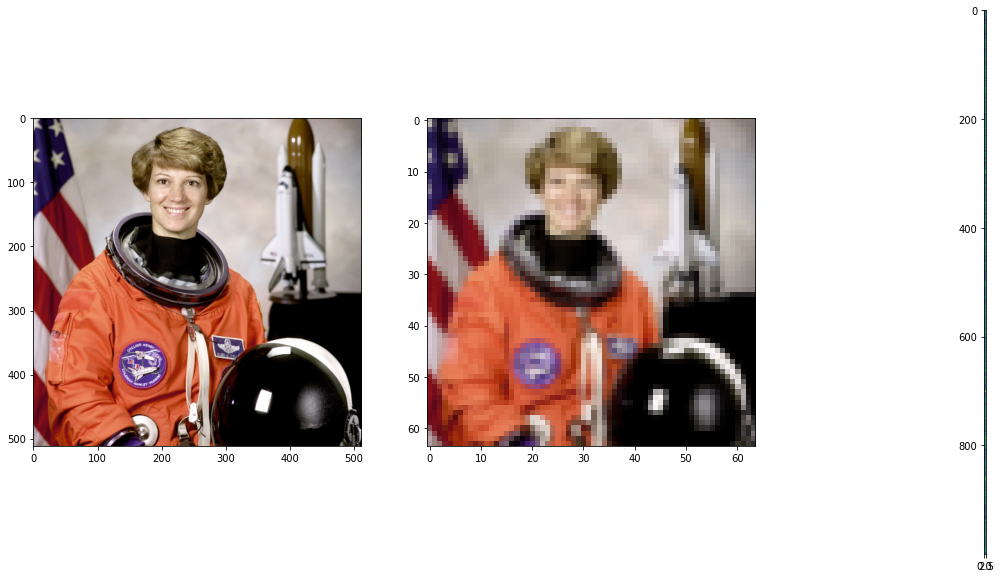

In [73]:
# Scale the values from [0,1] to [0, 255]
reconstructed_img = prediction.cpu() * 255

# Convert the tensor into a numpy array, and cast the type into uint8.
reconstructed_img = reconstructed_img.numpy().astype(np.uint8)

# Look at our creation next to the original!
fig, axes_array = plt.subplots(1, 3, figsize=(20, 10))
axes_array[0].imshow(img)
axes_array[1].imshow(smaller_img)
axes_array[2].imshow(reconstructed_img)
plt.show()

The images generated by CPPCs are generated by mathmetical algorithms and neural networks rather than being mechanically produced by means of a camera or other tools. The image produced here is based on an image taken by a camera, but it is produced by mapping the coordinates of the RGB pixels. The image produced can be manipulated by altering the network used to produce it; adding layers, using different optimisers, using different activation functions. This means that the image can be "grown" or evolved. 